In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
import os
import datetime as dt
from datetime import datetime
import bz2
import pickle
import _pickle as cPickle
import timeit
from __main__ import download_tickers, tickers

%matplotlib inline

In [ ]:
tickers = pd.read_csv('yfinanceetfs.csv', header=None)

In [ ]:
tickers = tickers[0].to_list()

In [118]:
tickers = ['SBUX']
#timeit.timeit("stocks = download_tickers(tickers)", "from __main__ import download_tickers, tickers", number=1)
stocks = download_tickers(tickers)

In [ ]:
import threading
threading.active_count()

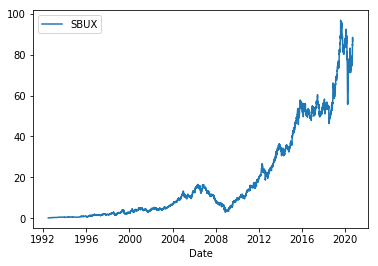

In [119]:
sns.lineplot(data=stocks.loc[:, stocks.columns.get_level_values(1).isin(['Adj Close'])])

In [120]:
def download_tickers(tickers):
    # Fetch downloaded ticker from raw_data
    downloaded_tickers = [x[0:-5] if '.pbz2' in x else '' for x in os.listdir('raw_data/')]
    downloaded_tickers.remove('')
    # Check if tickers already are downloaded
    tickers_to_download = []
    for ticker in tickers:
        if ticker in downloaded_tickers:
            # If already downloaded, check if they need updates
            if update_ticker(ticker):
                tickers_to_download.append(ticker)
        else:
            tickers_to_download.append(ticker)

    download_dump(tickers_to_download)
    
    # Read tickers from json and return
    return load_stocks(tickers)

In [121]:
def load_stocks(tickers):
    cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    index = pd.MultiIndex.from_product([tickers, cols], names=['Stock ticker', 'Data type'])
    if len(tickers) > 1:
        data = pd.concat([decompress_pickle('raw_data/' + x + '.pbz2') for x in tickers], axis=1, sort=True)
    else:
        data = decompress_pickle('raw_data/' + tickers[0] + '.pbz2')
    
    data.columns = index
    try:
        data.index = pd.to_datetime(data.index, unit='ms')
    except ValueError:
        data.index = pd.to_datetime(data.index)
    return data

In [122]:
def update_ticker(ticker):
    last_bday = last_weekday()
    newest_date = decompress_pickle('raw_data/' + ticker + '.pbz2').index[-1]
    if newest_date == float:
        newest_date = dt.datetime.fromtimestamp(newest_date/1000).date()
    if newest_date != last_bday:
        return True 
    else:
        return False

In [123]:
def download_dump(tickers):
    if tickers != []:
        data = yf.download(tickers, period='100y', group_by='tickers')
        if len(tickers) > 1:
            for ticker in tickers:
                    clean_data = clean_df(data[ticker])
                    #clean_data.to_json('raw_data/' + ticker + '.json', date_format='epoch', date_unit='ms')
                    compressed_pickle(ticker, clean_data[ticker])
        else:
            clean_data = clean_df(data)
            #clean_data.to_json('raw_data/' + tickers[0] + '.json', date_format='epoch', date_unit='ms')
            compressed_pickle(tickers[0], clean_data)

In [124]:
def last_weekday():
    todays_day = dt.date.today().day
    if todays_day in [5, 6]:
        return dt.date.today() - dt.timedelta(days=todays_day-4)
    else:
        return dt.date.today()


In [125]:
def clean_df(df):
    df = df.dropna(axis = 0, how='all')
    return df

In [126]:
def compressed_pickle(ticker, data):
    with bz2.BZ2File('raw_data/' + ticker + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

In [127]:
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [128]:
test = decompress_pickle('raw_data/AAPL.pbz2')

In [129]:
test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101261,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095978,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088934,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.091135,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093777,73449600
...,...,...,...,...,...,...
2020-08-31,127.580002,131.000000,126.000000,129.039993,129.039993,225702700
2020-09-01,132.759995,134.800003,130.529999,134.179993,134.179993,152470100
2020-09-02,137.589996,137.979996,127.000000,131.399994,131.399994,200119000


In [130]:
import os

def clean_raw_files():
    for filename in os.listdir('raw_data'):
        if filename.endswith(".pbz2"): 
            df = pd.DataFrame(decompress_pickle('raw_data/' + filename))
            non_zeroes = len(df) - df.iloc[:, 4].isna().sum()
            if non_zeroes < 2:
                os.remove('raw_data/' + filename)
            else:
                df = df.dropna(how='all', axis=0)
                ticker = filename.replace('.pbz2', '')
                compressed_pickle(ticker, df)
                  
remove_empties()